### MLP_4_Multivariate_multistep_time_series_forcast      

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras import metrics

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])
cell_1 = agg_by_cell.get_group('486-1252')
cell_11 = agg_by_cell.get_group('486-1253')
cell_2 = agg_by_cell.get_group('486-1256')
cell_22 = agg_by_cell.get_group('486-1257')
cell_3 = agg_by_cell.get_group('486-1258')
cell_33 = agg_by_cell.get_group('486-1259')
# define input sequence
series1 = cell_1['nr_people'].values
series11 = cell_11['nr_people'].values
series2 = cell_2['nr_people'].values
series22 = cell_22['nr_people'].values
series3 = cell_3['nr_people'].values
series33 = cell_33['nr_people'].values
print(type(series2))

<class 'numpy.ndarray'>


In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

# define input sequence
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))]) # convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
series11 = series11.reshape((len(series1), 1))
series22 = series22.reshape((len(series2), 1))
series33 = series33.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, series11, series22, series33,out_seq))
print('dataset dim', dataset.shape[1])

# choose a number of time steps
n_steps_in, n_steps_out = 5, 6

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

count = 0
for i in range(len(X)):
    count += 1
    print(X[i], y[i])
    if count > 2: break
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

dataset dim 7
[[ 36.  43.  42.  39.  44.  41. 121.]
 [ 36.  43.  42.  38.  44.  41. 121.]
 [ 34.  40.  40.  36.  42.  40. 114.]
 [ 33.  39.  39.  35.  40.  38. 111.]
 [ 32.  37.  37.  34.  38.  37. 106.]] [[ 33.  37.  37.  35.  38.  36. 107.]
 [ 32.  36.  35.  33.  37.  34. 103.]
 [ 30.  34.  34.  32.  36.  33.  98.]
 [ 30.  34.  33.  32.  35.  32.  97.]
 [ 29.  33.  32.  31.  34.  31.  94.]
 [ 29.  32.  31.  30.  33.  29.  92.]]
[[ 36.  43.  42.  38.  44.  41. 121.]
 [ 34.  40.  40.  36.  42.  40. 114.]
 [ 33.  39.  39.  35.  40.  38. 111.]
 [ 32.  37.  37.  34.  38.  37. 106.]
 [ 33.  37.  37.  35.  38.  36. 107.]] [[ 32.  36.  35.  33.  37.  34. 103.]
 [ 30.  34.  34.  32.  36.  33.  98.]
 [ 30.  34.  33.  32.  35.  32.  97.]
 [ 29.  33.  32.  31.  34.  31.  94.]
 [ 29.  32.  31.  30.  33.  29.  92.]
 [ 27.  30.  29.  28.  31.  27.  86.]]
[[ 34.  40.  40.  36.  42.  40. 114.]
 [ 33.  39.  39.  35.  40.  38. 111.]
 [ 32.  37.  37.  34.  38.  37. 106.]
 [ 33.  37.  37.  35.  38.  36. 

### Train -validation-test

In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
print(len(train_X), len(train_y), len(test_X), len(test_y), len(val_X), len(val_y))

5780 5780 3540 3540 2478 2478


### MLP Model

In [4]:
# define model
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_input)) 
model.add(Dense(250, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse',  metrics=[metrics.mae, 'accuracy'])

# fit model
model.fit(train_X, train_y, epochs=100, verbose=2)

Epoch 1/100
181/181 - 0s - loss: 193.7417 - mean_absolute_error: 7.9455 - accuracy: 0.2176
Epoch 2/100
181/181 - 0s - loss: 32.2650 - mean_absolute_error: 3.8935 - accuracy: 0.3221
Epoch 3/100
181/181 - 0s - loss: 27.3987 - mean_absolute_error: 3.5190 - accuracy: 0.4611
Epoch 4/100
181/181 - 0s - loss: 25.8356 - mean_absolute_error: 3.3938 - accuracy: 0.5138
Epoch 5/100
181/181 - 0s - loss: 24.8177 - mean_absolute_error: 3.3192 - accuracy: 0.5311
Epoch 6/100
181/181 - 0s - loss: 25.0148 - mean_absolute_error: 3.3392 - accuracy: 0.5344
Epoch 7/100
181/181 - 0s - loss: 25.7998 - mean_absolute_error: 3.3974 - accuracy: 0.5363
Epoch 8/100
181/181 - 0s - loss: 25.4968 - mean_absolute_error: 3.3603 - accuracy: 0.5367
Epoch 9/100
181/181 - 0s - loss: 24.8943 - mean_absolute_error: 3.3423 - accuracy: 0.5417
Epoch 10/100
181/181 - 0s - loss: 23.8735 - mean_absolute_error: 3.2421 - accuracy: 0.5407
Epoch 11/100
181/181 - 0s - loss: 24.5874 - mean_absolute_error: 3.3011 - accuracy: 0.5438
Epoch 1

181/181 - 0s - loss: 19.6893 - mean_absolute_error: 2.9398 - accuracy: 0.5820
Epoch 92/100
181/181 - 0s - loss: 19.1293 - mean_absolute_error: 2.8917 - accuracy: 0.5894
Epoch 93/100
181/181 - 0s - loss: 19.3521 - mean_absolute_error: 2.9032 - accuracy: 0.5881
Epoch 94/100
181/181 - 0s - loss: 19.2933 - mean_absolute_error: 2.9000 - accuracy: 0.5848
Epoch 95/100
181/181 - 0s - loss: 19.7806 - mean_absolute_error: 2.9425 - accuracy: 0.5843
Epoch 96/100
181/181 - 0s - loss: 19.3420 - mean_absolute_error: 2.9111 - accuracy: 0.5905
Epoch 97/100
181/181 - 0s - loss: 19.1846 - mean_absolute_error: 2.8861 - accuracy: 0.5846
Epoch 98/100
181/181 - 0s - loss: 18.6133 - mean_absolute_error: 2.8435 - accuracy: 0.5950
Epoch 99/100
181/181 - 0s - loss: 20.0120 - mean_absolute_error: 2.9843 - accuracy: 0.5844
Epoch 100/100
181/181 - 0s - loss: 19.3218 - mean_absolute_error: 2.9154 - accuracy: 0.5907


### Dimostra previsione

In [5]:
# demonstrate prediction
x_input = np.array([[ 36.,  43.,  42. , 39. , 44. , 41., 121.],
                    [ 36. , 43.,  42. , 38. , 44. , 41., 121.],
                    [ 34.  ,40. , 40. , 36. , 42. , 40., 114.],
                    [ 33. , 39. , 39. , 35. , 40. , 38., 111.],
                    [ 32. , 37. , 37. , 34. , 38. , 37., 106.]]) 
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 30.863367  35.692604  37.50667   32.949524  37.673122  36.452145
  103.02356   30.211117  35.34753   36.109993  32.552475  36.679436
   35.278343 100.31543   29.191929  34.127613  35.257465  31.717457
   35.84724   34.756435  98.68736   28.44259   32.90895   34.182526
   30.276487  34.89946   33.584908  96.76681   27.872675  32.0361
   33.468582  29.97525   34.045227  32.791317  94.489456  27.548819
   31.628567  32.592083  29.55639   33.06977   32.25887   92.965996]]


### Calcolo errore di previsione

In [6]:
predicted = np.array([])
for i in range(len(val_X)):
    x_input = val_X[i].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])

print(len(val_y))
var4diff2 = len(val_y)
print('shape ',val_y.shape )
val_y = val_y.reshape((val_y.shape[0] * val_y.shape[1]))    
expected = val_y    
print(len(expected))
print(len(predicted))    

2478
shape  (2478, 42)
104076
104076


### Distribuzione dell'errore

Mean Absolute Error =  2.8371087448910064


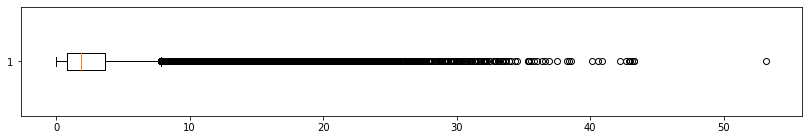

In [7]:
difference = abs(predicted - expected)
print('Mean Absolute Error = ', np.mean(difference))
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert = False)
plt.show()

### Distribuzione errore per ogni step

In [8]:
shape_i = dataset.shape[1] * n_steps_out 
print(var4diff2)
difference2 = difference.reshape( var4diff2, shape_i)
print(difference2.shape)


2478
(2478, 42)


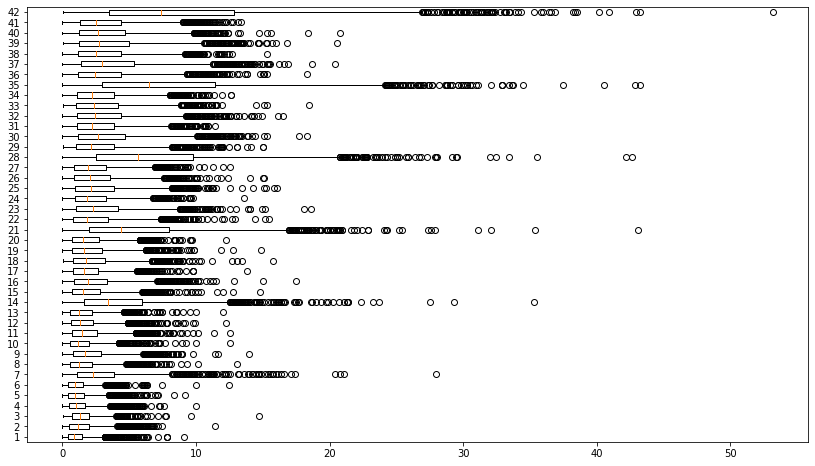

In [9]:
plt.figure(figsize = (14,8))
plt.boxplot(difference2, vert = False)
plt.show()